In [1]:
import os
from datasets import KITTIRAWDataset
from torch.utils.data import DataLoader


In [2]:
%cd CutLER/cutler/demo

/Users/ibrahimhassan/Documents/Documents/Frame_prediction/CutLER/cutler/demo


In [3]:
import argparse
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import cv2
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
import sys
# sys.path.append('./')
# sys.path.append('../')
sys.path.append(os.path.abspath('./'))
sys.path.append(os.path.abspath('../'))
from config import add_cutler_config
from predictor import VisualizationDemo

In [4]:
def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_cutler_config(cfg)
    # To use demo for Panoptic-DeepLab, please uncomment the following two lines.
    # from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config  # noqa
    # add_panoptic_deeplab_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    # Disable the use of SyncBN normalization when running on a CPU
    # SyncBN is not supported on CPU and can cause errors, so we switch to BN instead
    if cfg.MODEL.DEVICE == 'cpu' and cfg.MODEL.RESNETS.NORM == 'SyncBN':
        cfg.MODEL.RESNETS.NORM = "BN"
        cfg.MODEL.FPN.NORM = "BN"
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    return cfg

In [5]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input", help="path to the input image",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.35,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [6]:
# provide arguments for running CutLER demo.

# Note: Using ***CPU*** by default. to run on GPU, remove "MODEL.DEVICE", "cpu".
# Note: please specify a path with "--input" if you want to try your own images.
# Note: you can use a lower --confidence-threshold to get a higher recall.
mp.set_start_method("spawn", force=True)
inputs = ['--config-file', "../model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN_demo.yaml", '--input', "imgs/demo1.jpg", '--confidence-threshold', '0.5', "--opts", "MODEL.WEIGHTS", "cutler_cascade_final.pth", "MODEL.DEVICE", "cpu"]
args = get_parser(inputs)

In [7]:
setup_logger(name="fvcore")
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup_cfg(args)
demo = VisualizationDemo(cfg)

[10/23 18:16:15 detectron2]: Arguments: Namespace(config_file='../model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN_demo.yaml', webcam=False, video_input=None, input='imgs/demo1.jpg', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[10/23 18:16:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[10/23 18:16:16 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...


/Users/ibrahimhassan/anaconda3/envs/frame_pred/lib/python3.10/site-packages/fvcore/common/checkpoint.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(

In [8]:
kitti_demo = "/Users/ibrahimhassan/Documents/Documents/ekf-imu-depth-v2/kitti/2011_09_26/2011_09_26_drive_0093_sync/image_02/data/0000000041.jpg"

In [9]:
# use PIL, to be consistent with evaluation
# img = read_image(args.input, format="BGR")
img = read_image(kitti_demo, format="BGR")
# img = kitti_demo
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)
logger.info(
    "{}: {} in {:.2f}s".format(
        args.input,
        "detected {} instances".format(len(predictions["instances"]))
        if "instances" in predictions
        else "finished",
        time.time() - start_time,
    )
)

# save image to your local directory
if args.output:
    if os.path.isdir(args.output):
        assert os.path.isdir(args.output), args.output
        out_filename = os.path.join(args.output, os.path.basename(args.input))
    else:
        assert len(args.input) == 1, "Please specify a directory with args.output"
        out_filename = args.output
    visualized_output.save(out_filename)

/Users/ibrahimhassan/anaconda3/envs/frame_pred/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636886/work/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/23 18:16:33 detectron2]: imgs/demo1.jpg: detected 2 instances in 1.41s


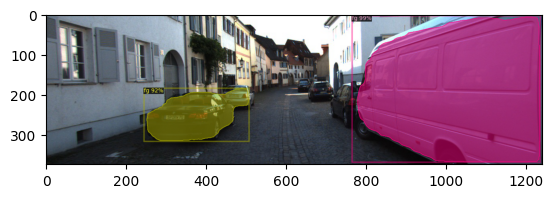

In [10]:
plt.imshow(visualized_output.get_image())

Now test with normal image and then its corresponding depth map

In [14]:
normal_image = "/Users/ibrahimhassan/Documents/Documents/Frame_prediction/Report_images_1/500000_0.png"

In [15]:
# use PIL, to be consistent with evaluation
# img = read_image(args.input, format="BGR")
img = read_image(normal_image, format="BGR")
# img = kitti_demo
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)
logger.info(
    "{}: {} in {:.2f}s".format(
        args.input,
        "detected {} instances".format(len(predictions["instances"]))
        if "instances" in predictions
        else "finished",
        time.time() - start_time,
    )
)

# save image to your local directory
if args.output:
    if os.path.isdir(args.output):
        assert os.path.isdir(args.output), args.output
        out_filename = os.path.join(args.output, os.path.basename(args.input))
    else:
        assert len(args.input) == 1, "Please specify a directory with args.output"
        out_filename = args.output
    visualized_output.save(out_filename)

[10/23 18:18:44 detectron2]: imgs/demo1.jpg: detected 2 instances in 1.66s


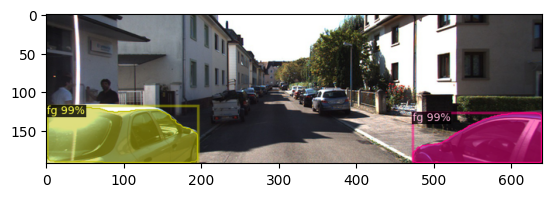

In [16]:
plt.imshow(visualized_output.get_image())

Now test with a depth map

In [11]:
depth_map = "/Users/ibrahimhassan/Documents/Documents/Frame_prediction/Report_images_1/600000_0.png"

In [12]:
# use PIL, to be consistent with evaluation
# img = read_image(args.input, format="BGR")
img = read_image(depth_map, format="BGR")
# img = kitti_demo
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)
logger.info(
    "{}: {} in {:.2f}s".format(
        args.input,
        "detected {} instances".format(len(predictions["instances"]))
        if "instances" in predictions
        else "finished",
        time.time() - start_time,
    )
)

# save image to your local directory
if args.output:
    if os.path.isdir(args.output):
        assert os.path.isdir(args.output), args.output
        out_filename = os.path.join(args.output, os.path.basename(args.input))
    else:
        assert len(args.input) == 1, "Please specify a directory with args.output"
        out_filename = args.output
    visualized_output.save(out_filename)

[10/23 18:17:32 detectron2]: imgs/demo1.jpg: detected 0 instances in 1.27s


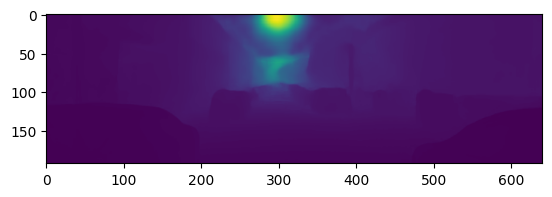

In [13]:
plt.imshow(visualized_output.get_image())